In [1]:
# Append 'src' directory to import modules from notebooks directory
#################################
import os,sys
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)
##################################

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 150)

import time
import os 
from src.PatchMatch import PatchMatchOrig
import torchvision.models as models
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.model_zoo as model_zoo
import cv2
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict
from PIL import Image
from src.models import VGG19
from src import Utils

Populating the interactive namespace from numpy and matplotlib


In [35]:
img2_path = './cat.jpeg'
img1_path = './ann.jpg'

img1 = Utils.load_image(img_path=img1_path,to_array=True,to_variable=True)
img2 = Utils.load_image(img_path=img2_path,to_array=True,to_variable=True)

In [36]:
model = VGG19()

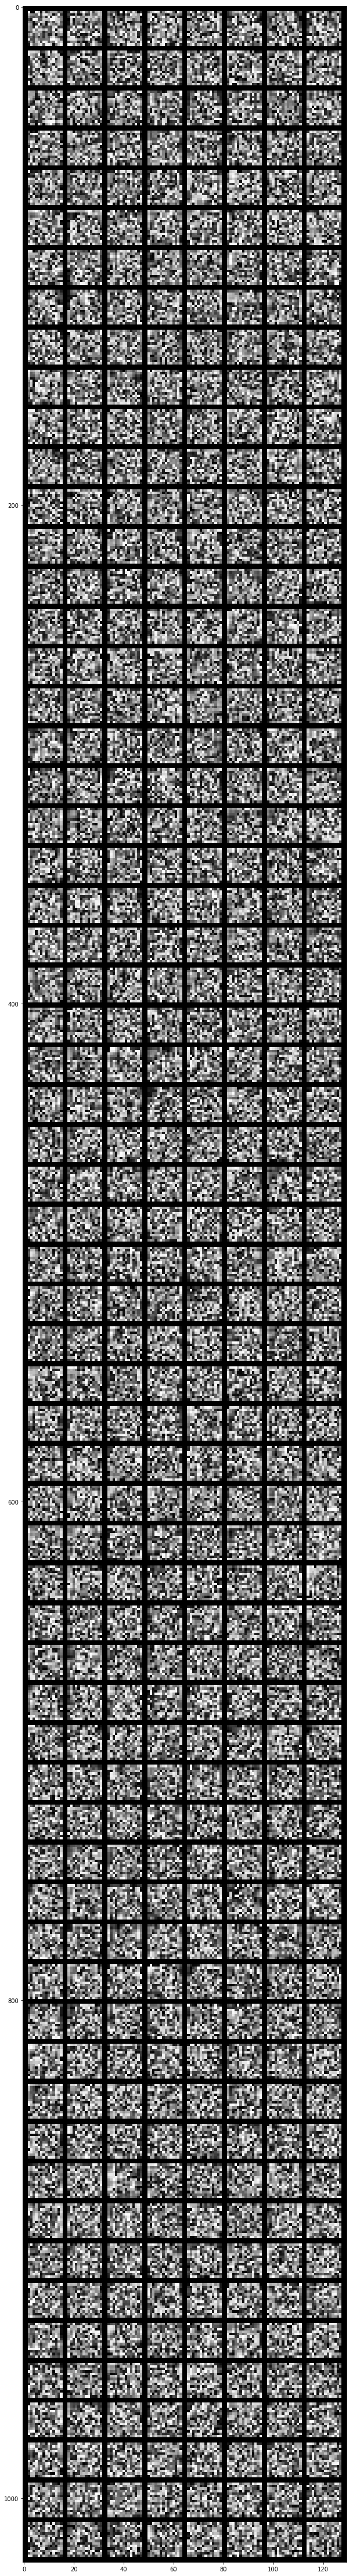

In [37]:
feat1 = model.get_features_for_layer(img_tensor=img1,layer_num=-7).squeeze().numpy()
feat2 = model.get_features_for_layer(img_tensor=img2,layer_num=-7).squeeze().numpy()
plt.imshow(Utils.get_viz_tensor(torch.from_numpy(feat1)))

In [38]:
feat1_norm = feat1/(feat1.max()-feat1.min())
feat2_norm = feat2/(feat2.max() - feat2.min() )

# feat1_norm = feat1/(feat1.max())
# feat2_norm = feat2/(feat2.max() )


feat1_np_t = feat1_norm.transpose(1,2,0)
feat2_np_t = feat2_norm.transpose(1,2,0)

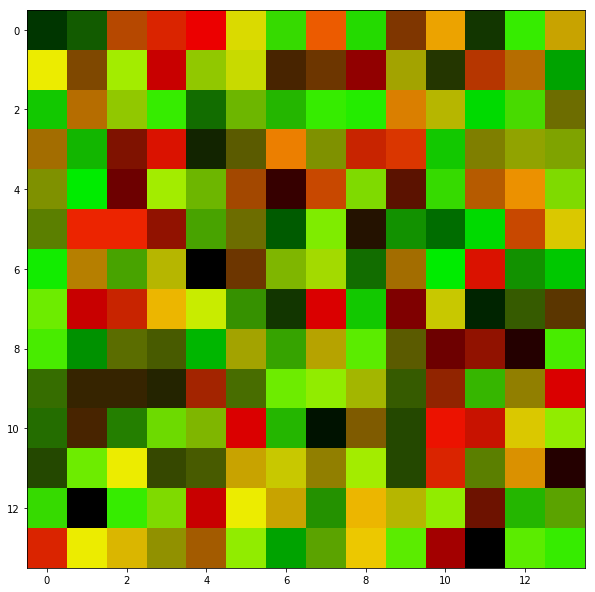

In [39]:
pm = PatchMatchOrig(feat1_np_t,feat2_np_t, 3)
plt.imshow(pm.visualize())

done iteration 1
done iteration 2
done iteration 3
done iteration 4
done iteration 5
Done


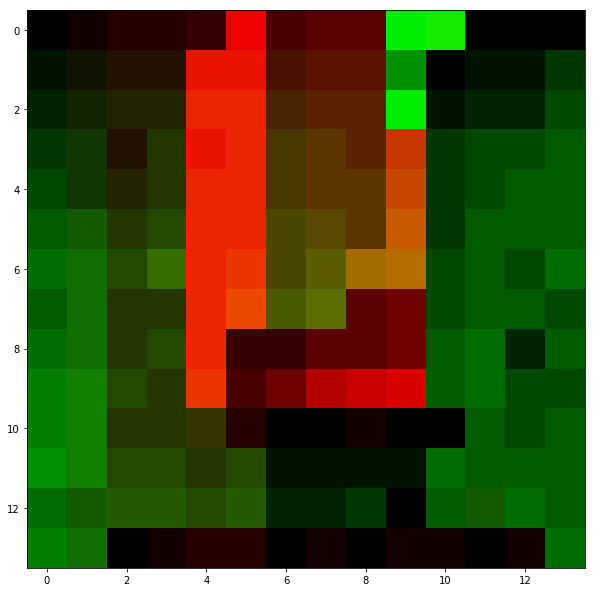

In [40]:
pm.propagate(iters=5,rand_search_radius=6)
plt.imshow(pm.visualize())

In [41]:
img1_raw = Utils.load_image(img_path=img2_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
img2_raw = Utils.load_image(img_path=img1_path,to_array=False,to_variable=False).numpy().transpose(1,2,0)
img2_raw.shape


(224, 224, 3)

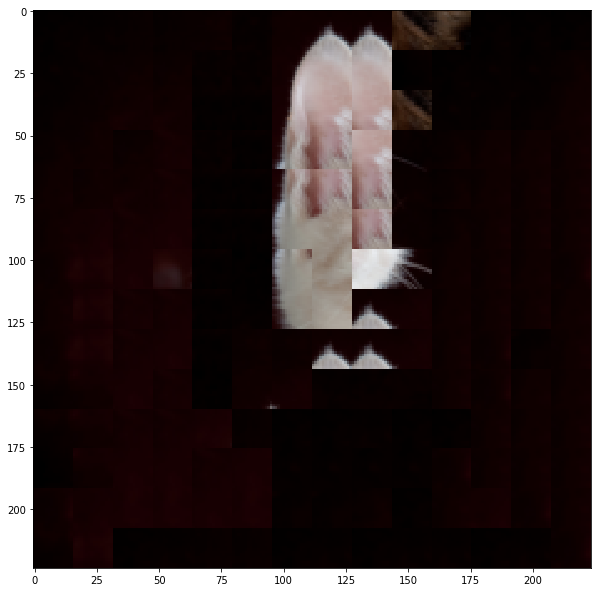

In [42]:
recon = Utils.reconstruct_image(img1_raw,img2_raw,scale=16,size=14,pm=pm)
plt.imshow(Utils.deprocess_image(recon))